# MNIST Handwritten Digit Classification using CNN

## 1. Project Introduction & Problem Definition

**Objective:** Build a Convolutional Neural Network (CNN) to classify handwritten digits (0-9) from the MNIST dataset.

**Dataset:** MNIST - 70,000 grayscale images of handwritten digits (28x28 pixels)
- Training set: 60,000 images
- Test set: 10,000 images

**Deep Learning Lifecycle Stages:**
1. Problem Definition 
2. Data Collection & Loading
3. Exploratory Data Analysis (EDA)
4. Data Preprocessing & Augmentation
5. Model Architecture Design
6. Model Training & Validation
7. Model Evaluation & Testing
8. Results Visualization
9. Model Deployment/Saving

## 2. Environment Setup & Library Imports

In [1]:
# Core Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning Framework
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Display settings
plt.style.use('seaborn-v0_8-whitegrid')
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow Version: 2.20.0
GPU Available: []


## 3. Data Loading & Collection

In [2]:
# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Display dataset information
print("=" * 50)
print("DATASET INFORMATION")
print("=" * 50)
print(f"\nTraining Set:")
print(f"  - Images shape: {X_train.shape}")
print(f"  - Labels shape: {y_train.shape}")
print(f"\nTest Set:")
print(f"  - Images shape: {X_test.shape}")
print(f"  - Labels shape: {y_test.shape}")
print(f"\nImage Properties:")
print(f"  - Image dimensions: {X_train.shape[1]}x{X_train.shape[2]} pixels")
print(f"  - Pixel value range: [{X_train.min()}, {X_train.max()}]")
print(f"  - Data type: {X_train.dtype}")

DATASET INFORMATION

Training Set:
  - Images shape: (60000, 28, 28)
  - Labels shape: (60000,)

Test Set:
  - Images shape: (10000, 28, 28)
  - Labels shape: (10000,)

Image Properties:
  - Image dimensions: 28x28 pixels
  - Pixel value range: [0, 255]
  - Data type: uint8


## 4. Exploratory Data Analysis (EDA)

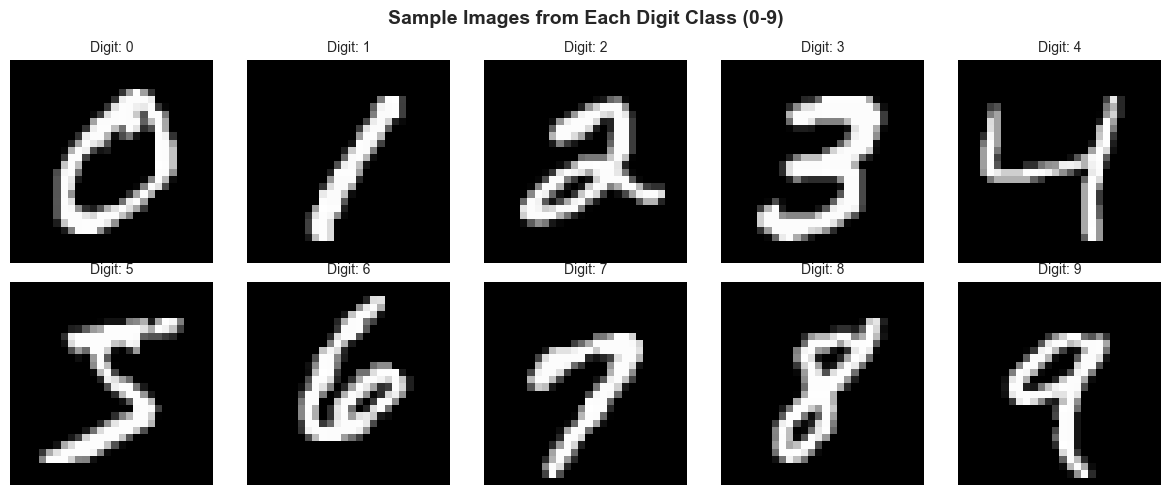

In [3]:
# Visualize sample images from each class
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Sample Images from Each Digit Class (0-9)', fontsize=14, fontweight='bold')

for digit in range(10):
    # Find first occurrence of each digit
    idx = np.where(y_train == digit)[0][0]
    ax = axes[digit // 5, digit % 5]
    ax.imshow(X_train[idx], cmap='gray')
    ax.set_title(f'Digit: {digit}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

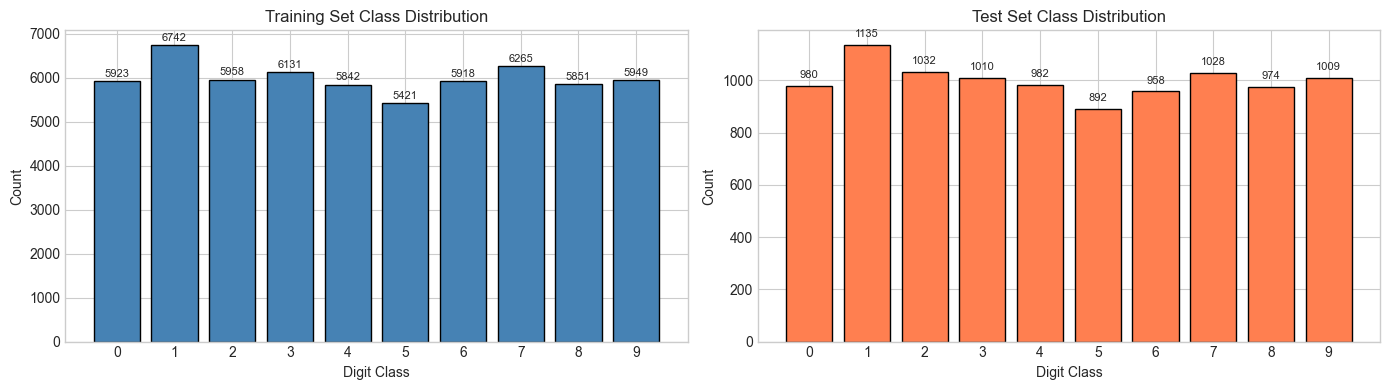


Class Balance Check:
  - Training set - Min: 5421, Max: 6742
  - Test set - Min: 892, Max: 1135


In [4]:
# Analyze class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Training set distribution
unique_train, counts_train = np.unique(y_train, return_counts=True)
axes[0].bar(unique_train, counts_train, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Digit Class')
axes[0].set_ylabel('Count')
axes[0].set_title('Training Set Class Distribution')
axes[0].set_xticks(range(10))
for i, (count, digit) in enumerate(zip(counts_train, unique_train)):
    axes[0].text(digit, count + 100, str(count), ha='center', fontsize=8)

# Test set distribution
unique_test, counts_test = np.unique(y_test, return_counts=True)
axes[1].bar(unique_test, counts_test, color='coral', edgecolor='black')
axes[1].set_xlabel('Digit Class')
axes[1].set_ylabel('Count')
axes[1].set_title('Test Set Class Distribution')
axes[1].set_xticks(range(10))
for i, (count, digit) in enumerate(zip(counts_test, unique_test)):
    axes[1].text(digit, count + 30, str(count), ha='center', fontsize=8)

plt.tight_layout()
plt.show()

print(f"\nClass Balance Check:")
print(f"  - Training set - Min: {counts_train.min()}, Max: {counts_train.max()}")
print(f"  - Test set - Min: {counts_test.min()}, Max: {counts_test.max()}")

## 5. Data Preprocessing & Preparation

In [5]:
# Store original shapes for reference
original_train_shape = X_train.shape
original_test_shape = X_test.shape

# 5.1 Reshape images to include channel dimension (required for CNN)
# Shape: (samples, height, width) -> (samples, height, width, channels)
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

# 5.2 Normalize pixel values from [0, 255] to [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# 5.3 One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes=10)
y_test_encoded = to_categorical(y_test, num_classes=10)

# Display preprocessing summary
print("=" * 50)
print("DATA PREPROCESSING SUMMARY")
print("=" * 50)
print(f"\nReshaping:")
print(f"  - Original shape: {original_train_shape}")
print(f"  - New shape: {X_train.shape}")
print(f"\nNormalization:")
print(f"  - Pixel range: [{X_train.min():.1f}, {X_train.max():.1f}]")
print(f"\nLabel Encoding (One-Hot):")
print(f"  - Original label example: {y_train[0]}")
print(f"  - Encoded label example: {y_train_encoded[0]}")

DATA PREPROCESSING SUMMARY

Reshaping:
  - Original shape: (60000, 28, 28)
  - New shape: (60000, 28, 28, 1)

Normalization:
  - Pixel range: [0.0, 1.0]

Label Encoding (One-Hot):
  - Original label example: 5
  - Encoded label example: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [6]:
# 5.4 Create validation split from training data
from sklearn.model_selection import train_test_split

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train_encoded, 
    test_size=0.2, 
    random_state=42,
    stratify=y_train
)

print("=" * 50)
print("FINAL DATA SPLITS")
print("=" * 50)
print(f"\nTraining set:   {X_train_final.shape[0]:,} samples")
print(f"Validation set: {X_val.shape[0]:,} samples")
print(f"Test set:       {X_test.shape[0]:,} samples")
print(f"\nTotal samples:  {X_train_final.shape[0] + X_val.shape[0] + X_test.shape[0]:,}")

FINAL DATA SPLITS

Training set:   48,000 samples
Validation set: 12,000 samples
Test set:       10,000 samples

Total samples:  70,000


## 6. Model Architecture Design

**CNN Architecture:**
- Input Layer: 28×28×1 grayscale images
- Conv2D → MaxPooling2D → Conv2D → MaxPooling2D → Conv2D
- Flatten → Dense → Dropout → Dense (Output)

**Key Design Choices:**
- ReLU activation for hidden layers (avoids vanishing gradient)
- Softmax activation for output (multi-class classification)
- Dropout for regularization (prevents overfitting)
- BatchNormalization for faster training convergence

In [7]:
def build_cnn_model(input_shape=(28, 28, 1), num_classes=10):
    """
    Build a Convolutional Neural Network for image classification.
    
    Args:
        input_shape: Shape of input images (height, width, channels)
        num_classes: Number of output classes
    
    Returns:
        Compiled Keras model
    """
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, 
                      padding='same', name='conv1'),
        layers.BatchNormalization(name='bn1'),
        layers.MaxPooling2D((2, 2), name='pool1'),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2'),
        layers.BatchNormalization(name='bn2'),
        layers.MaxPooling2D((2, 2), name='pool2'),
        
        # Third Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv3'),
        layers.BatchNormalization(name='bn3'),
        
        # Flatten and Dense Layers
        layers.Flatten(name='flatten'),
        layers.Dense(128, activation='relu', name='dense1'),
        layers.Dropout(0.5, name='dropout'),
        layers.Dense(num_classes, activation='softmax', name='output')
    ], name='MNIST_CNN')
    
    return model

# Build the model
model = build_cnn_model()

# Display model architecture
print("=" * 50)
print("MODEL ARCHITECTURE")
print("=" * 50)
model.summary()

MODEL ARCHITECTURE


Model: "MNIST_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 28, 28, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 14, 14, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 7, 7, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 459,210 (1.75 MB)

 Trainable params: 458,890 (1.75 MB)

 Non-trainable params: 320 (1.25 KB)

In [12]:
# Visualize model architecture
from tensorflow.keras.utils import plot_model

try:
    plot_model(model, to_file='model_architecture.png', 
               show_shapes=True, show_layer_names=True, dpi=100)
    print("Model architecture saved to 'model_architecture.png'")
except Exception as e:
    print(f"Note: Could not save model visualization ({e})")
    print("Install graphviz for model visualization: conda install graphviz pydot")

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
Model architecture saved to 'model_architecture.png'


## 7. Model Compilation & Training Configuration

**Training Configuration:**
- Optimizer: Adam (adaptive learning rate)
- Loss Function: Categorical Cross-Entropy (multi-class classification)
- Metrics: Accuracy

**Callbacks:**
- EarlyStopping: Prevent overfitting by stopping when validation loss stops improving
- ReduceLROnPlateau: Reduce learning rate when validation loss plateaus
- ModelCheckpoint: Save the best model during training

In [9]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks for training
callback_list = [
    # Early stopping to prevent overfitting
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate when validation loss plateaus
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    
    # Save the best model
    callbacks.ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Model compiled successfully!")
print(f"\nOptimizer: Adam (lr=0.001)")
print(f"Loss: Categorical Cross-Entropy")
print(f"Metrics: Accuracy")

Model compiled successfully!

Optimizer: Adam (lr=0.001)
Loss: Categorical Cross-Entropy
Metrics: Accuracy


## 8. Model Training

In [13]:
# Training hyperparameters
EPOCHS = 20
BATCH_SIZE = 64

print("=" * 50)
print("TRAINING CONFIGURATION")
print("=" * 50)
print(f"\nEpochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Training Samples: {X_train_final.shape[0]:,}")
print(f"Validation Samples: {X_val.shape[0]:,}")
print(f"Steps per Epoch: {X_train_final.shape[0] // BATCH_SIZE}")
print("\n" + "=" * 50)
print("Starting Training...")
print("=" * 50)

# Train the model
history = model.fit(
    X_train_final, y_train_final,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callback_list,
    verbose=1
)

print("\n" + "=" * 50)
print("Training Complete!")
print("=" * 50)

TRAINING CONFIGURATION

Epochs: 20
Batch Size: 64
Training Samples: 48,000
Validation Samples: 12,000
Steps per Epoch: 750

Starting Training...
Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9824 - loss: 0.0626
Epoch 1: val_accuracy improved from 0.98042 to 0.98883, saving model to best_model.keras

Epoch 1: finished saving model to best_model.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.9819 - loss: 0.0654 - val_accuracy: 0.9888 - val_loss: 0.0397 - learning_rate: 0.0010
Epoch 2/20
748/750 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9846 - loss: 0.0523
Epoch 2: val_accuracy did not improve from 0.98883
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.9847 - loss: 0.0530 - val_accuracy: 0.9876 - val_loss: 0.0415 - learning_rate: 0.0010
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9879 - loss: 0.0411
Epoch 3: val_accuracy did not improve from 0.98883
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.9878 - l

## 9. Training History Visualization

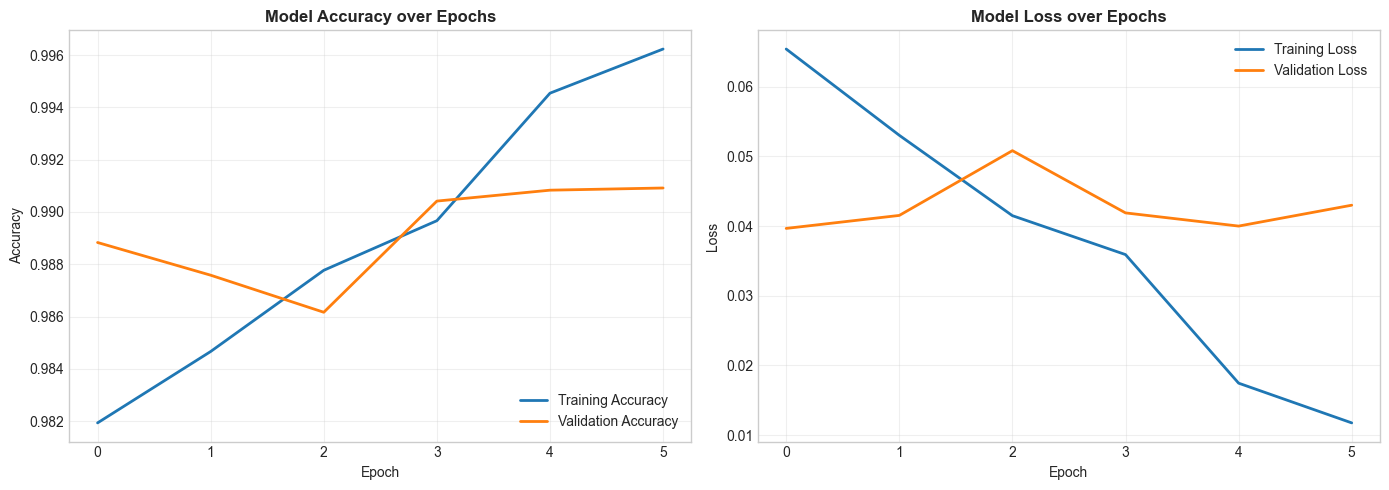


TRAINING SUMMARY

Final Training Accuracy:   0.9962
Final Validation Accuracy: 0.9909
Final Training Loss:       0.0117
Final Validation Loss:     0.0430

Best Validation Accuracy:  0.9909
Best Validation Loss:      0.0397


In [15]:
def plot_training_history(history):
    """Plot training and validation metrics."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot Accuracy
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0].set_title('Model Accuracy over Epochs', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)
    
    # Plot Loss
    axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[1].set_title('Model Loss over Epochs', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print final metrics
    print("\n" + "=" * 50)
    print("TRAINING SUMMARY")
    print("=" * 50)
    print(f"\nFinal Training Accuracy:   {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Final Training Loss:       {history.history['loss'][-1]:.4f}")
    print(f"Final Validation Loss:     {history.history['val_loss'][-1]:.4f}")
    print(f"\nBest Validation Accuracy:  {max(history.history['val_accuracy']):.4f}")
    print(f"Best Validation Loss:      {min(history.history['val_loss']):.4f}")

# Visualize training history
plot_training_history(history)

## 10. Model Evaluation on Test Set

In [16]:
# Evaluate on test set
print("=" * 50)
print("MODEL EVALUATION ON TEST SET")
print("=" * 50)

test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)

print(f"\nTest Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"\nTotal Test Samples: {X_test.shape[0]:,}")
print(f"Correctly Classified: {int(test_accuracy * X_test.shape[0]):,}")
print(f"Misclassified: {int((1-test_accuracy) * X_test.shape[0]):,}")

MODEL EVALUATION ON TEST SET

Test Loss:     0.0315
Test Accuracy: 0.9898 (98.98%)

Total Test Samples: 10,000
Correctly Classified: 9,897
Misclassified: 102


In [17]:
# Generate predictions
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = y_test

# Classification Report
print("=" * 50)
print("CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_true, y_pred, 
                            target_names=[f'Digit {i}' for i in range(10)]))

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Digit 0       1.00      0.99      0.99       980
     Digit 1       0.99      1.00      0.99      1135
     Digit 2       1.00      0.99      0.99      1032
     Digit 3       0.98      1.00      0.99      1010
     Digit 4       0.99      0.99      0.99       982
     Digit 5       0.99      0.98      0.99       892
     Digit 6       0.99      0.99      0.99       958
     Digit 7       0.99      0.99      0.99      1028
     Digit 8       0.99      0.99      0.99       974
     Digit 9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



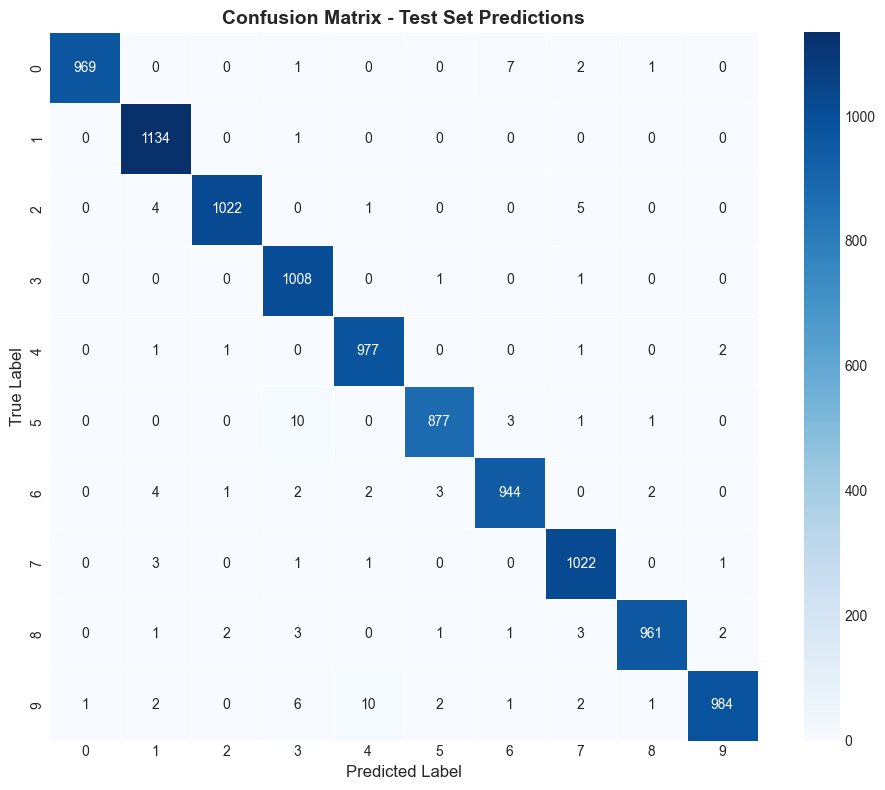


PER-CLASS ACCURACY
Digit 0: 969/980 (98.88%)
Digit 1: 1134/1135 (99.91%)
Digit 2: 1022/1032 (99.03%)
Digit 3: 1008/1010 (99.80%)
Digit 4: 977/982 (99.49%)
Digit 5: 877/892 (98.32%)
Digit 6: 944/958 (98.54%)
Digit 7: 1022/1028 (99.42%)
Digit 8: 961/974 (98.67%)
Digit 9: 984/1009 (97.52%)


In [18]:
# Confusion Matrix Visualization
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10),
            square=True, linewidths=0.5)
plt.title('Confusion Matrix - Test Set Predictions', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Per-class accuracy
print("\n" + "=" * 50)
print("PER-CLASS ACCURACY")
print("=" * 50)
for i in range(10):
    class_correct = cm[i, i]
    class_total = cm[i, :].sum()
    print(f"Digit {i}: {class_correct}/{class_total} ({class_correct/class_total*100:.2f}%)")

## 11. Prediction Visualization & Error Analysis

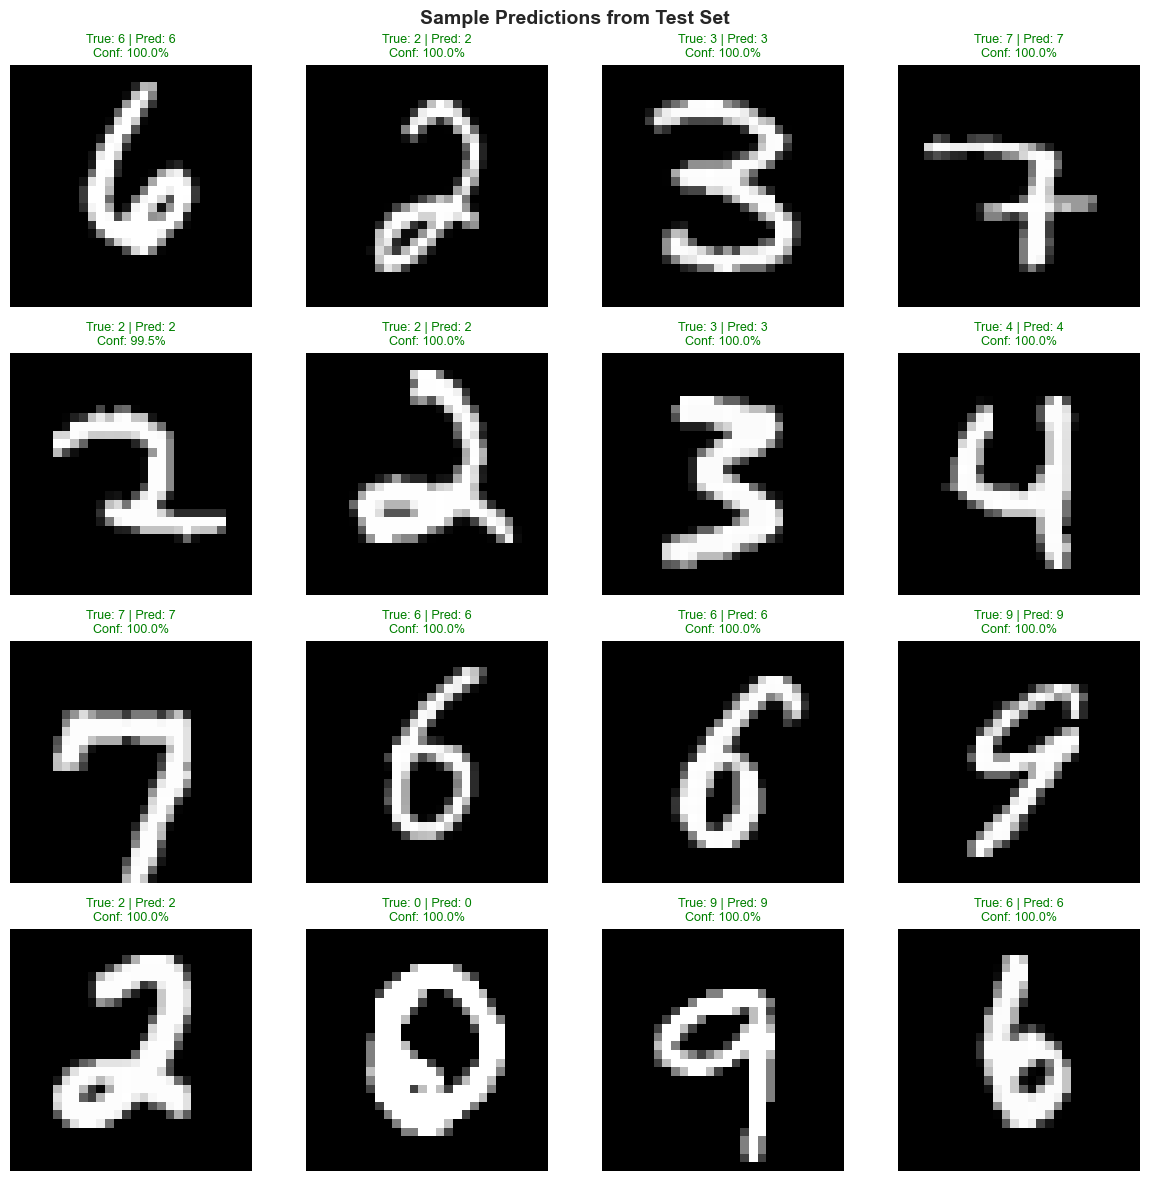

In [19]:
# Visualize sample predictions
def plot_predictions(images, true_labels, pred_labels, pred_proba, n_samples=16):
    """Plot sample predictions with confidence scores."""
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    fig.suptitle('Sample Predictions from Test Set', fontsize=14, fontweight='bold')
    
    indices = np.random.choice(len(images), n_samples, replace=False)
    
    for idx, ax in zip(indices, axes.flat):
        ax.imshow(images[idx].reshape(28, 28), cmap='gray')
        
        true_label = true_labels[idx]
        pred_label = pred_labels[idx]
        confidence = pred_proba[idx][pred_label] * 100
        
        color = 'green' if true_label == pred_label else 'red'
        ax.set_title(f'True: {true_label} | Pred: {pred_label}\nConf: {confidence:.1f}%', 
                     color=color, fontsize=9)
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('sample_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

# Plot sample predictions
plot_predictions(X_test, y_true, y_pred, y_pred_proba)

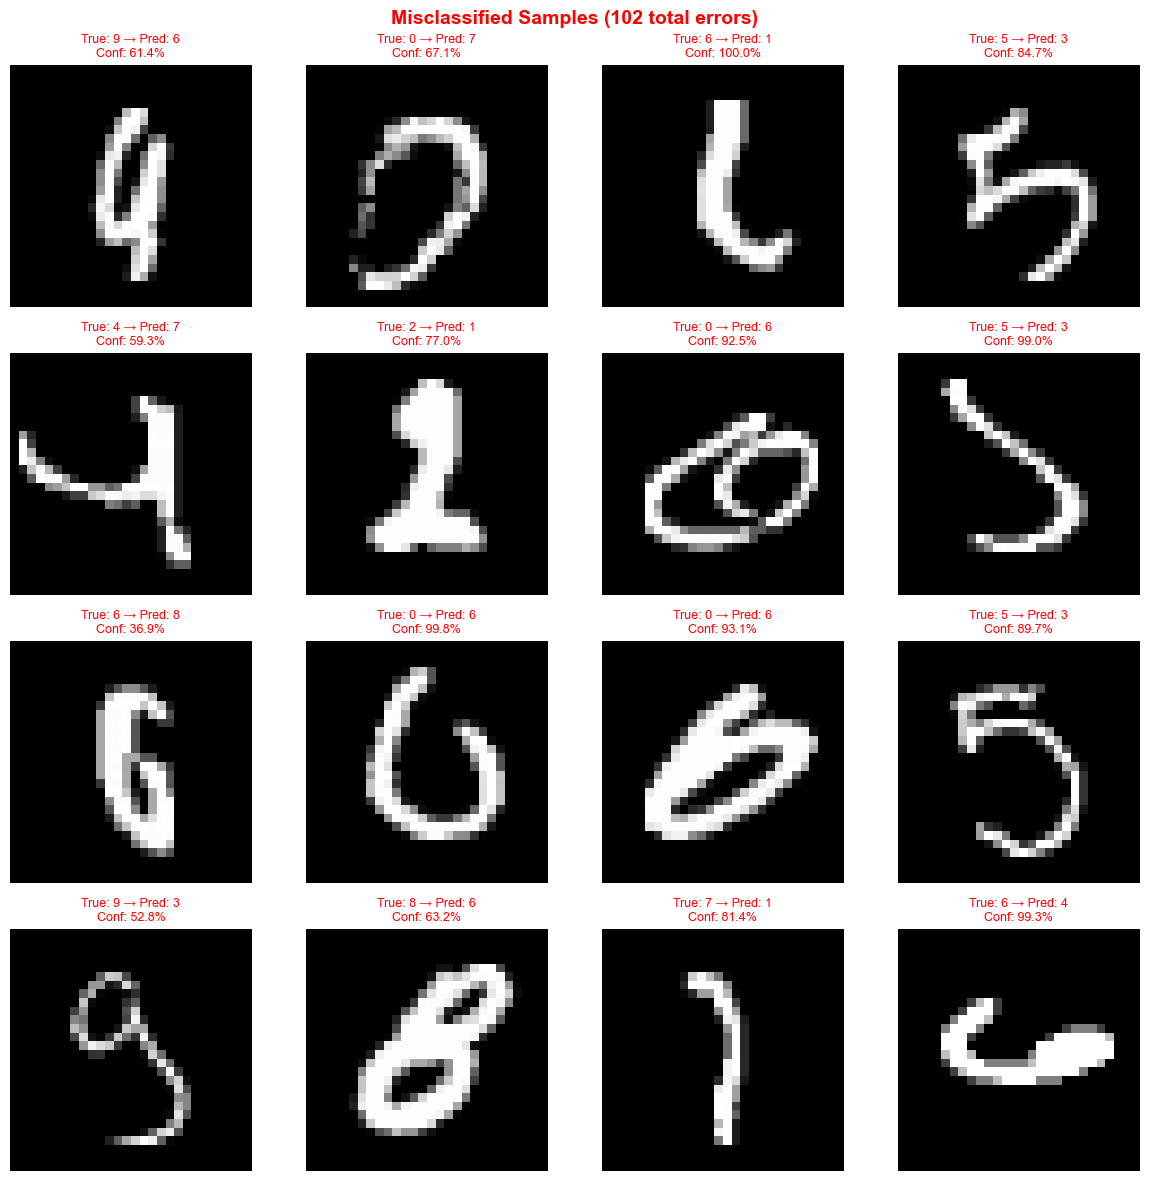


COMMON MISCLASSIFICATION PATTERNS

Top 10 most common errors (True → Predicted):
  5 → 3: 10 times
  9 → 4: 10 times
  0 → 6: 7 times
  9 → 3: 6 times
  2 → 7: 5 times
  2 → 1: 4 times
  6 → 1: 4 times
  6 → 5: 3 times
  7 → 1: 3 times
  8 → 3: 3 times


In [20]:
# Error Analysis - Visualize misclassified samples
def plot_misclassified(images, true_labels, pred_labels, pred_proba, n_samples=16):
    """Plot misclassified samples for error analysis."""
    # Find misclassified indices
    misclassified_idx = np.where(true_labels != pred_labels)[0]
    
    if len(misclassified_idx) == 0:
        print("No misclassified samples found!")
        return
    
    n_samples = min(n_samples, len(misclassified_idx))
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    fig.suptitle(f'Misclassified Samples ({len(misclassified_idx)} total errors)', 
                 fontsize=14, fontweight='bold', color='red')
    
    sample_idx = np.random.choice(misclassified_idx, n_samples, replace=False)
    
    for idx, ax in zip(sample_idx, axes.flat):
        ax.imshow(images[idx].reshape(28, 28), cmap='gray')
        
        true_label = true_labels[idx]
        pred_label = pred_labels[idx]
        confidence = pred_proba[idx][pred_label] * 100
        
        ax.set_title(f'True: {true_label} → Pred: {pred_label}\nConf: {confidence:.1f}%', 
                     color='red', fontsize=9)
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('misclassified_samples.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Analyze common misclassification patterns
    print("\n" + "=" * 50)
    print("COMMON MISCLASSIFICATION PATTERNS")
    print("=" * 50)
    from collections import Counter
    errors = [(t, p) for t, p in zip(true_labels[misclassified_idx], 
                                      pred_labels[misclassified_idx])]
    common_errors = Counter(errors).most_common(10)
    print("\nTop 10 most common errors (True → Predicted):")
    for (true_val, pred_val), count in common_errors:
        print(f"  {true_val} → {pred_val}: {count} times")

# Plot misclassified samples
plot_misclassified(X_test, y_true, y_pred, y_pred_proba)

## 12. Model Saving & Export

In [21]:
# Save the final trained model
model.save('mnist_cnn_final.keras')
print("Model saved as 'mnist_cnn_final.keras'")

# Save model weights separately
model.save_weights('mnist_cnn_weights.weights.h5')
print("Weights saved as 'mnist_cnn_weights.weights.h5'")

# Save training history
import json
history_dict = {key: [float(v) for v in values] for key, values in history.history.items()}
with open('training_history.json', 'w') as f:
    json.dump(history_dict, f, indent=2)
print("Training history saved as 'training_history.json'")

print("\n" + "=" * 50)
print("ALL ARTIFACTS SAVED SUCCESSFULLY")
print("=" * 50)

Model saved as 'mnist_cnn_final.keras'
Weights saved as 'mnist_cnn_weights.weights.h5'
Training history saved as 'training_history.json'

ALL ARTIFACTS SAVED SUCCESSFULLY


## 13. Model Inference Demo (Loading & Predicting)

Model loaded successfully!

INFERENCE DEMO


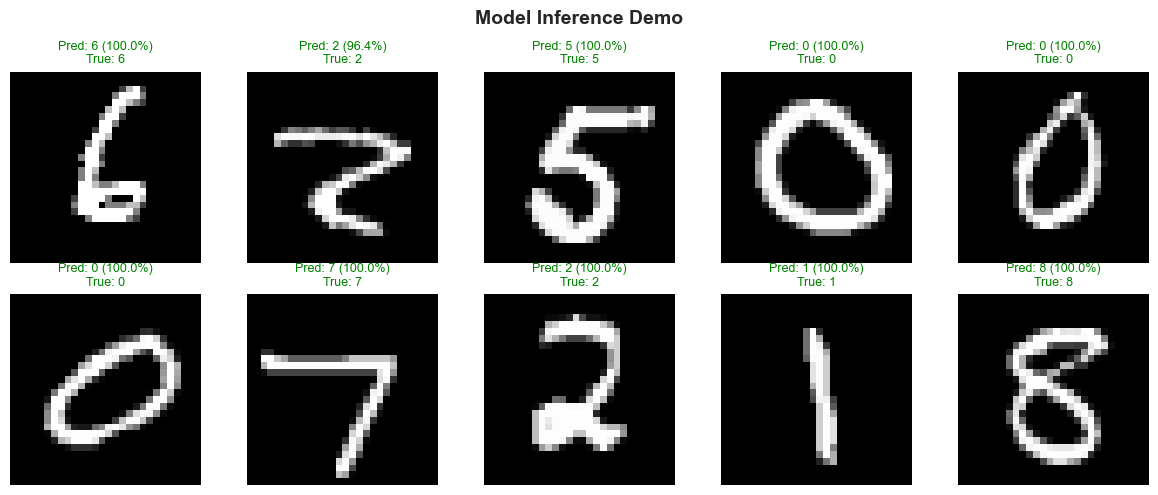

In [22]:
# Load the saved model for inference
loaded_model = tf.keras.models.load_model('mnist_cnn_final.keras')
print("Model loaded successfully!")

# Function to predict a single image
def predict_digit(model, image):
    """
    Predict the digit from a single image.
    
    Args:
        model: Trained Keras model
        image: Grayscale image (28x28) or (28x28x1)
    
    Returns:
        predicted_digit, confidence
    """
    # Preprocess the image - handle both 2D and 3D inputs
    if image.ndim == 2:
        # Raw image (28, 28) -> add channel and batch dimensions
        image = image.reshape(1, 28, 28, 1)
    elif image.ndim == 3:
        # Already has channel dim (28, 28, 1) -> add batch dimension
        image = np.expand_dims(image, axis=0)
    
    # Normalize if not already normalized
    if image.max() > 1:
        image = image.astype('float32') / 255.0
    
    # Make prediction
    prediction = model.predict(image, verbose=0)
    predicted_digit = np.argmax(prediction)
    confidence = prediction[0][predicted_digit]
    
    return predicted_digit, confidence

# Demo: Predict random test samples
print("\n" + "=" * 50)
print("INFERENCE DEMO")
print("=" * 50)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Model Inference Demo', fontsize=14, fontweight='bold')

for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(X_test))
    sample_image = X_test[idx]
    true_label = y_test[idx]
    
    pred_digit, conf = predict_digit(loaded_model, sample_image)
    
    ax.imshow(sample_image.reshape(28, 28), cmap='gray')
    color = 'green' if pred_digit == true_label else 'red'
    ax.set_title(f'Pred: {pred_digit} ({conf*100:.1f}%)\nTrue: {true_label}', 
                 color=color, fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()